# RSCV Model building

### Import Modules

In [27]:
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy.stats import randint

In [28]:
print(np.__version__)

2.0.0


In [29]:
import sklearn

sklearn.show_versions()


System:
    python: 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:23:07) [GCC 12.3.0]
executable: /home/fhwn.ac.at/202375/.conda/envs/thesis/bin/python
   machine: Linux-5.15.0-101-generic-x86_64-with-glibc2.31

Python dependencies:
      sklearn: 1.5.0
          pip: 24.0
   setuptools: 70.0.0
        numpy: 2.0.0
        scipy: 1.13.1
       Cython: None
       pandas: 2.2.2
   matplotlib: 3.8.4
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 80
         prefix: libopenblas
       filepath: /home/fhwn.ac.at/202375/.conda/envs/thesis/lib/libopenblasp-r0.3.27.so
        version: 0.3.27
threading_layer: pthreads
   architecture: SkylakeX

       user_api: openmp
   internal_api: openmp
    num_threads: 80
         prefix: libgomp
       filepath: /home/fhwn.ac.at/202375/.conda/envs/thesis/lib/libgomp.so.1.0.0
        version: None


### Define Paths

In [30]:
# sys.path.clear()

# Basepath
basepath = "../"  # Project directory
sys.path.append(basepath)

# Data
DATA_PATH = basepath + "data"

# Results path
RESULTS_PATH = basepath + "03_Modelling/03_1_rscv/rscv_results/"

# Figure path
FIGURE_PATH = basepath + "03_Modelling/03_1_rscv/rscv_figures/"

# Path to environment
ENV_PATH = "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib"

# Modelpath
MODEL_PATH = basepath + "models"

# Logging
LOG_DIR = basepath + "03_Modelling/03_1_rscv/"

# Active Learning library
AL_PATH = basepath + "al_lib"

# Add the paths
sys.path.extend(
    {DATA_PATH, FIGURE_PATH, ENV_PATH, MODEL_PATH, RESULTS_PATH, LOG_DIR, AL_PATH}
)
sys.path  # Check if the path is correct

['/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python312.zip',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/lib-dynload',
 '',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages',
 '../',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib',
 '../03_Modelling/03_1_rscv/',
 '../03_Modelling/03_1_rscv/rscv_figures/',
 '../models',
 '../al_lib',
 '../data',
 '../03_Modelling/03_1_rscv/rscv_results/',
 '../',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib',
 '../03_Modelling/03_1_rscv/',
 '../03_Modelling/03_1_rscv/rscv_figures/',
 '../models',
 '../al_lib',
 '../data',
 '../03_Modelling/03_1_rscv/rscv_results/']

### Logging

In [31]:
LOG_DIR

'../03_Modelling/03_1_rscv/'

In [32]:
# import the logging specifications from file 'logging_config.py'
from al_lib.logging_config import create_logger
import datetime

# Add data/time information
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

# Define the notebook name and the output name
notebook_name = "03_1_rscv.ipynb"  # Is also used when saving the notebook
output_name = f"{notebook_name.split('.')[0]}_{date}.html"

# Specify logging location
log_file_name = f"{notebook_name.split('.')[0]}_{date}.log"
log_file_dir = f"{LOG_DIR}"
log_file_path = f"{LOG_DIR}/{log_file_name}"
# print(f"Log file path: {log_file_path}")

# Get the logger
# logger = None
logging = create_logger(__name__, log_file_path=log_file_path)

# Usage of the logger as follows:
logging.info("Logging started")

2024-06-26 21:30:52 - INFO - Logging started


### Import Data

#### Import PS20191107_2deriv_gegl.csv

In [33]:
# Import 2nd_deriv

data_ps2019_2deriv = pd.read_csv(
    DATA_PATH + "/PS20191107_2deriv_gegl.csv",
    on_bad_lines="skip",
    sep=";",
    decimal=",",
    encoding="utf-8",
)

data_ps2019_2deriv = data_ps2019_2deriv.rename(columns={"Unnamed: 0": "Name"})

# Convert all columns of type 'object' to 'float' or 'int' if possible
for column in data_ps2019_2deriv.columns:
    # change datatype from the 'year' column to 'int
    if column == "year":
        data_ps2019_2deriv[column] = data_ps2019_2deriv[column].astype("int")
        print(f"'{column}' has been converted to 'int'.")
        # skip the rest of the loop
        continue
    try:
        data_ps2019_2deriv[column] = data_ps2019_2deriv[column].astype("float")
        # data_small.select_dtypes(include=['object']).astype('float')
    except ValueError:
        print(
            f"'{column}' could not be converted(ValueError). Continue with other column(s)."
        )
    except TypeError:
        print(
            f"'{column}' could not be converted(TypeError). Continue with other column(s)."
        )

'Name' could not be converted(ValueError). Continue with other column(s).
'year' has been converted to 'int'.
'Origin' could not be converted(ValueError). Continue with other column(s).
'type' could not be converted(ValueError). Continue with other column(s).


In [34]:
data_ps2019_2deriv.shape  # for quality control purposes

(2244, 1870)

## Import dpsDeriv1200.csv

In [35]:
data_dps_deriv_1200 = pd.read_csv(
    DATA_PATH + "/dpsDeriv1200.csv", sep=",", decimal=".", encoding="utf-8"
)
data_dps_deriv_1200 = data_dps_deriv_1200.rename(columns=lambda x: x.replace("X", ""))
data_dps_deriv_1200 = data_dps_deriv_1200.rename(columns={"Unnamed: 0": "Samplename"})
data_dps_deriv_1200

,Samplename,year,tree,Origin,type,2970,2968,2966,2964,2962,...,818,816,814,812,810,808,806,804,802,800
0,2GOS-18_1955,1955,2GOS-18,POL,living,-7.236150e-08,4.010600e-07,0.000005,1.310370e-05,1.788600e-05,...,-4.740000e-06,-0.000020,-0.000034,-0.000045,-0.000052,-0.000054,-0.000049,-0.000038,-0.000023,-0.000011
1,2GOS-18_1969,1969,2GOS-18,POL,living,1.739940e-05,4.649250e-06,-0.000007,-1.769050e-05,-2.597300e-05,...,-2.730000e-07,-0.000016,-0.000031,-0.000042,-0.000046,-0.000045,-0.000040,-0.000031,-0.000019,-0.000007
2,2GOS-18_1974,1974,2GOS-18,POL,living,1.629130e-05,1.129150e-05,0.000006,5.111420e-07,-5.256790e-06,...,-1.890000e-06,-0.000014,-0.000025,-0.000036,-0.000043,-0.000046,-0.000043,-0.000035,-0.000023,-0.000013
3,2GOS-18_1976,1976,2GOS-18,POL,living,9.659060e-06,4.122150e-06,0.000003,4.831610e-06,3.334600e-06,...,-1.630000e-06,-0.000016,-0.000030,-0.000043,-0.000052,-0.000055,-0.000051,-0.000040,-0.000025,-0.000012
4,2GOS-18_1996,1996,2GOS-18,POL,living,9.218540e-06,3.989240e-06,-0.000006,-1.145560e-05,-6.957740e-06,...,2.350000e-07,-0.000010,-0.000023,-0.000037,-0.000047,-0.000052,-0.000050,-0.000044,-0.000035,-0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,SZLPS15a_1942,1942,SZLPS15a,AUT,living,1.930000e-06,-1.740000e-06,-0.000005,-4.760000e-06,1.920000e-07,...,-9.250000e-06,-0.000026,-0.000041,-0.000054,-0.000063,-0.000064,-0.000059,-0.000047,-0.000032,-0.000016
1286,SZLPS15a_1952,1952,SZLPS15a,AUT,living,1.410000e-06,-4.960000e-06,-0.000010,-6.870000e-06,2.740000e-06,...,-5.970000e-06,-0.000025,-0.000042,-0.000056,-0.000063,-0.000064,-0.000058,-0.000046,-0.000030,-0.000015
1287,SZLPS15a_1962,1962,SZLPS15a,AUT,living,-1.980000e-06,-3.530000e-06,-0.000002,3.120000e-06,9.860000e-06,...,-6.480000e-06,-0.000026,-0.000044,-0.000058,-0.000065,-0.000064,-0.000055,-0.000042,-0.000027,-0.000013
1288,SZLPS15a_1972,1972,SZLPS15a,AUT,living,3.140000e-06,-5.210000e-06,-0.000011,-9.600000e-06,-1.490000e-06,...,-1.120000e-06,-0.000020,-0.000038,-0.000055,-0.000066,-0.000069,-0.000064,-0.000052,-0.000036,-0.000020


## Select Data

In [36]:
# Switch for the dataset
# Select from (data_small, data_full, data_2nd_deriv) or other if implemented
data_raw = data_dps_deriv_1200
data_raw.dataset_name = "data_dps_deriv_1200"
logging.info(f"Dataset: {data_raw.dataset_name}")
logging.info(f"Size of the dataset: {data_raw.shape}")

2024-06-26 21:30:55 - INFO - Dataset: data_dps_deriv_1200
2024-06-26 21:30:55 - INFO - Size of the dataset: (1290, 415)


## Modelling Parameters

In [37]:
# Define the parameters for the CV

# Switch for testing mode (use only 10% of the data, among others)
testing = False

# Define a random state for randomized processes
random_state = np.random.RandomState(202375)

if testing == True:
    nfolds = 5
    NoTrials = 5
    n_jobs = 20
    save_model = False
    # data = data_raw.sample(frac=0.15, random_state=random_state)
    data = data_raw
    logging.info(f"Size of the dataset reduced: {data.shape}")
else:
    nfolds = 10
    NoTrials = 15
    n_jobs = 20
    save_model = True
    data = data_raw
    logging.info(f"Size of the dataset not reduced: {data.shape}")

# Log the modelling parameters
logging.info(
    f"Testing for Cross Validation: {testing}, nfolds: {nfolds}, NoTrials: {NoTrials}, n_jobs: {n_jobs}"
)

2024-06-26 21:30:55 - INFO - Size of the dataset not reduced: (1290, 415)
2024-06-26 21:30:55 - INFO - Testing for Cross Validation: False, nfolds: 10, NoTrials: 15, n_jobs: 20


## Preprocessing

To apply the models we need to split the data into the variables and target.

In [38]:
data.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [39]:
data.dtypes.value_counts()

float64    410
object       4
int64        1
Name: count, dtype: int64

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Columns: 415 entries, Samplename to 800
dtypes: float64(410), int64(1), object(4)
memory usage: 4.1+ MB


In [41]:
data.describe()

,year,2970,2968,2966,2964,2962,2960,2959,2957,2955,...,818,816,814,812,810,808,806,804,802,800
count,1290.000000,1290.000000,1290.000000,1.290000e+03,1290.000000,1290.000000,1.290000e+03,1290.000000,1290.000000,1290.000000,...,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000
mean,1740.420930,0.000012,0.000005,-9.431341e-07,-0.000005,-0.000006,-4.172513e-06,0.000001,0.000009,0.000017,...,-0.000008,-0.000028,-0.000045,-0.000057,-0.000061,-0.000059,-0.000050,-0.000038,-0.000023,-0.000009
std,196.420289,0.000014,0.000012,1.202741e-05,0.000013,0.000017,1.994992e-05,0.000022,0.000022,0.000019,...,0.000010,0.000012,0.000013,0.000014,0.000013,0.000011,0.000010,0.000009,0.000008,0.000007
min,1194.000000,-0.000027,-0.000039,-1.000000e-04,-0.000149,-0.000182,-1.940000e-04,-0.000183,-0.000191,-0.000163,...,-0.000040,-0.000060,-0.000082,-0.000099,-0.000110,-0.000105,-0.000094,-0.000079,-0.000057,-0.000032
25%,1616.000000,0.000004,-0.000002,-7.924335e-06,-0.000011,-0.000012,-1.076210e-05,-0.000006,0.000002,0.000010,...,-0.000016,-0.000036,-0.000055,-0.000066,-0.000069,-0.000066,-0.000056,-0.000043,-0.000029,-0.000014
50%,1769.000000,0.000011,0.000005,-2.170000e-07,-0.000003,-0.000003,-2.638125e-07,0.000005,0.000013,0.000020,...,-0.000009,-0.000028,-0.000045,-0.000057,-0.000062,-0.000059,-0.000050,-0.000037,-0.000023,-0.000009
75%,1913.000000,0.000019,0.000012,6.660000e-06,0.000004,0.000004,7.850000e-06,0.000014,0.000022,0.000028,...,-0.000001,-0.000019,-0.000035,-0.000047,-0.000053,-0.000052,-0.000045,-0.000032,-0.000018,-0.000004
max,2009.000000,0.000116,0.000086,4.120000e-05,0.000025,0.000030,3.550000e-05,0.000046,0.000053,0.000063,...,0.000023,0.000003,-0.000013,-0.000019,-0.000021,-0.000021,-0.000016,-0.000009,0.000002,0.000013


In [42]:
# Split into target and features
# The goal is to predict the year column of the dataset using the spectral data
X = data.select_dtypes("float")
y = data["year"]
X.shape, y.shape

((1290, 410), (1290,))

In [43]:
# count the number of columns with std = 0.0 in X
logging.info(
    f"Number of columns to be dropped, where std = 0.0 in X: {(X.std() == 0.0).sum()}"
)

2024-06-26 21:30:56 - INFO - Number of columns to be dropped, where std = 0.0 in X: 0


In [44]:
# drop the columns with std = 0.0
X = X.loc[:, X.std() != 0.0]
logging.info(f"Dimensions of X after dropping columns with std = 0.0: {X.shape}")
logging.info(f"Dimensions of Y: {y.shape}")

2024-06-26 21:30:56 - INFO - Dimensions of X after dropping columns with std = 0.0: (1290, 410)
2024-06-26 21:30:56 - INFO - Dimensions of Y: (1290,)


In [45]:
# Split the data into training and test sets
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)
logging.info(f"random split with testsize {test_size} into training and test sets")

2024-06-26 21:30:56 - INFO - random split with testsize 0.3 into training and test sets


In [46]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# assert the shapes and raise an error if they are not equal
assert X_train.shape[0] + X_test.shape[0] == X.shape[0]
assert y_train.shape[0] + y_test.shape[0] == y.shape[0]

## Define Score metrics

In [47]:
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error

# create a scorer which calculates Root Mean Squeared Error (RMSE)

scoring = make_scorer(root_mean_squared_error, greater_is_better=False)
# scoring = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
logging.info(f"Scorer: {scoring}")

2024-06-26 21:30:56 - INFO - Scorer: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')


# Modeling with Randomized Search Crossvalidation (RSCV)

#### Models

In [48]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.neural_network import MLPRegressor as MLP
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor as HGB
from sklearn.ensemble import RandomForestRegressor

## Hyperparameter Definition

Randomized Search CV is usefull for the efficient exploration of a large parameter space. The results can consequently be used to design a fine grid for the Grid Search CV

In [49]:
# load the Hyperparameter distributions for the RandomizedSearchCV
from al_lib.rscv_parameters import (
    rf_rscv_parameters,
    pls_rscv_parameters,
    krr_rscv_parameters,
    mlp_rscv_parameters,
    xgb_rscv_parameters,
    hgb_rscv_parameters,
)

# to update the import without restarting the kernel, uncoment and modify the following line
# del <model>_parameters

In [50]:
import pandas as pd
import numpy as np

models = {
    "rf": RandomForestRegressor(),
    "pls": PLSRegression(),
    "krr": KRR(),
    "mlp": MLP(),
    "xgb": XGBRegressor(),
    "hgb": HGB(),
}

# Prepare objects to store the results
# Template:
# rf_rscv_results = pd.DataFrame(columns=["model", "MAE", "RMSE", "params"])
for model in models.keys():
    globals()[f"{model}_rscv_results"] = pd.DataFrame(
        columns=["model", "MAE", "RMSE", "params"]
    )
    print(f"{model}_rscv_parameters")

rf_rscv_parameters
pls_rscv_parameters
krr_rscv_parameters
mlp_rscv_parameters
xgb_rscv_parameters
hgb_rscv_parameters


In [51]:
from al_lib.helper_functions import rmse_func as rmse
from al_lib.helper_functions import report_model
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import (
    mean_squared_error,
)  # also imports the neg_root_mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import make_scorer


# create a scorer which calculates Root Mean Squeared Error (RMSE)


def rscv(
    features,
    target,
    model,
    param_distributions,
    results_file,
    random_state,
    NoTrials=5,
    nfolds=4,
    n_jobs=5,
    scoring=scoring,  #
):
    """_summary_

    Args:
        features (_type_): _description_
        target (_type_): _description_
        model (_type_): _description_
        param_distributions (_type_): _description_
        results_file (_type_): _description_
        random_state (_type_): _description_
        NoTrials (int, optional): _description_. Defaults to 5.
        nfolds (int, optional): _description_. Defaults to 4.
        n_jobs (int, optional): _description_. Defaults to 5.
        scoring (_type_, optional): _description_. Defaults to scoring.

    Returns:
        _type_: _description_
    """
    logging.info(f"STARTED the RandomizedSearchCV for {model} with {NoTrials} trials")
    # log the args
    logging.info(
        f"Features: {features.shape}, Target: {target.shape}, Model: {model}, Param_distributions: {param_distributions}, Results File: {results_file} Random_state: {random_state}, NoTrials: {NoTrials}, nfolds: {nfolds}, n_jobs: {n_jobs}, Scoring: {scoring}"
    )
    logging.info(f"Results file: {results_file}")

    # prepare the result object 1
    rscv_results = pd.DataFrame(columns=["model", "MAE", "RMSE", "params"])

    # define the train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.3, random_state=random_state
    )
    # create the result objects 2
    rscv_rmse_inner = np.zeros(NoTrials)
    rscv_rmse_outer = np.zeros(NoTrials)

    for i in range(NoTrials):
        logging.info(f"Trial: {i} out of {NoTrials}")
        # split for nested cross-validation
        inner_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)

        # non-nested parameter search and scoring
        rscv = RandomizedSearchCV(
            model,
            param_distributions=param_distributions,
            n_iter=10,
            cv=inner_cv,
            random_state=random_state,
            scoring=scoring,
            n_jobs=n_jobs,
        )

        # fit
        rscv.fit(X_train, y_train)
        # make predictions to later estimate the generalization error
        y_pred = cvp(rscv, X_test, y_test, cv=outer_cv, n_jobs=n_jobs)
        all_predictions = np.zeros((len(y_test), NoTrials))
        all_predictions[:, i] = y_pred
        # calculate the RMSE for the inner and outer CV
        rscv_rmse_inner[i] = rscv.best_score_

        # calculate the RMSE for the outer CV
        # rscv_rmse_outer[i] = np.sqrt(mean_squared_error(y_test, y_pred))
        rscv_rmse_outer[i] = rmse(y_test, y_pred)
        # store the results
        rscv_results.loc[i, "model"] = rscv.estimator
        rscv_results.loc[i, "MAE"] = mean_absolute_error(y_test, y_pred)
        rscv_results.loc[i, "RMSE"] = np.sqrt(mean_squared_error(y_test, y_pred))
        rscv_results.at[i, "params"] = rscv.best_params_
        report_model(rscv)

    # write results into outputifle
    rscv_results.to_csv(results_file, index=False, mode="a")
    logging.info(f"FINISHED the RandomizedSearchCV for {model} with {NoTrials} trials")
    return rscv_results
    # the goal of the rscv is to find the optimal hyperparameters
    # for further investigation we want to store
    # the 10 best model parameters and their scores
    # both the inner and outer cv scores, as well as the score difference

# Random Forest Regressor - RSCV

In [52]:
rf = RandomForestRegressor()
rf_rscv_results_file = f"{RESULTS_PATH}rf_rscv_results.csv"

rscv(
    features=X,
    target=y,
    model=rf,
    param_distributions=rf_rscv_parameters,
    results_file=rf_rscv_results_file,
    random_state=random_state,
)

2024-06-26 21:30:56 - INFO - STARTED the RandomizedSearchCV for RandomForestRegressor() with 5 trials
2024-06-26 21:30:56 - INFO - Features: (1290, 410), Target: (1290,), Model: RandomForestRegressor(), Param_distributions: {'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0a5ccb9b80>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0a5db446b0>, 'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0a5ccc54c0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0a5ce6b2c0>}, Results File: ../03_Modelling/03_1_rscv/rscv_results/rf_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 5, nfolds: 4, n_jobs: 5, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-26 21:30:56 - INFO - Results file: ../03_Modelling/03_1_rscv/rscv_results/rf_rscv_results.csv
2024-06-26 21:30:56 - INFO - Trial: 0 ou

Best hyperparameters for RandomForestRegressor: {'max_depth': 12, 'max_features': 7, 'min_samples_split': 11, 'n_estimators': 53}
Best score -113.80513101583304 for RandomForestRegressor: -113.80513101583304
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=12, max_features=7, min_samples_split=11,
                      n_estimators=53)


2024-06-26 21:31:17 - INFO - Trial: 2 out of 5


Best hyperparameters for RandomForestRegressor: {'max_depth': 18, 'max_features': 7, 'min_samples_split': 2, 'n_estimators': 59}
Best score -112.97631591549381 for RandomForestRegressor: -112.97631591549381
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=18, max_features=7, n_estimators=59)


2024-06-26 21:31:24 - INFO - Trial: 3 out of 5


Best hyperparameters for RandomForestRegressor: {'max_depth': 11, 'max_features': 6, 'min_samples_split': 8, 'n_estimators': 68}
Best score -114.20182763479832 for RandomForestRegressor: -114.20182763479832
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=11, max_features=6, min_samples_split=8,
                      n_estimators=68)


2024-06-26 21:31:34 - INFO - Trial: 4 out of 5


Best hyperparameters for RandomForestRegressor: {'max_depth': 17, 'max_features': 5, 'min_samples_split': 10, 'n_estimators': 73}
Best score -115.67248737578002 for RandomForestRegressor: -115.67248737578002
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=17, max_features=5, min_samples_split=10,
                      n_estimators=73)


2024-06-26 21:31:44 - INFO - FINISHED the RandomizedSearchCV for RandomForestRegressor() with 5 trials


Best hyperparameters for RandomForestRegressor: {'max_depth': 19, 'max_features': 5, 'min_samples_split': 3, 'n_estimators': 73}
Best score -113.83163579300623 for RandomForestRegressor: -113.83163579300623
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=19, max_features=5, min_samples_split=3,
                      n_estimators=73)


,model,MAE,RMSE,params
0,RandomForestRegressor(),95.143078,120.583176,"{'max_depth': 12, 'max_features': 7, 'min_samp..."
1,RandomForestRegressor(),99.774429,125.393344,"{'max_depth': 18, 'max_features': 7, 'min_samp..."
2,RandomForestRegressor(),101.042063,126.318098,"{'max_depth': 11, 'max_features': 6, 'min_samp..."
3,RandomForestRegressor(),99.405088,124.908492,"{'max_depth': 17, 'max_features': 5, 'min_samp..."
4,RandomForestRegressor(),100.892086,126.871083,"{'max_depth': 19, 'max_features': 5, 'min_samp..."


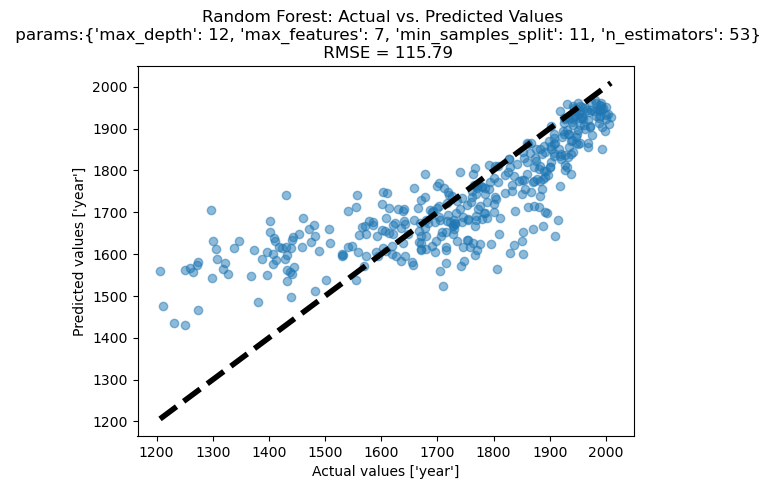

In [53]:
# generate the actual vs. predicted plot
from al_lib.helper_functions import plot_actual_vs_pred

# import the optimal model parameters
rf_results = pd.read_csv(rf_rscv_results_file)
# select the model parameters with the lowest RMSE
optimal_params_str_rf = rf_results.loc[rf_results["RMSE"].idxmin(), "params"]
optimal_params_rf = dict(eval(optimal_params_str_rf))

rf_opt = RandomForestRegressor(**optimal_params_rf)

y_pred_rf = rf_opt.fit(X_train, y_train).predict(X_test)

title_str = (
    f"Random Forest: Actual vs. Predicted Values \n params:"
    + optimal_params_str_rf
    + f"\n RMSE = {root_mean_squared_error(y_test, y_pred_rf):.2f}"
)

param_dict = {"title": title_str}
fig_path = f"{FIGURE_PATH}avp_rf.png"
fig, ax = plt.subplots(1, 1)
rf_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_rf, param_dict, fig_path)

# PLS Regressor - RSCV


In [54]:
from sklearn import cross_decomposition

pls = cross_decomposition.PLSRegression()
pls_rscv_results_file = f"{RESULTS_PATH}/pls_rscv_results.csv"


rscv(
    features=X,
    target=y,
    model=pls,
    param_distributions=pls_rscv_parameters,
    results_file=pls_rscv_results_file,
    random_state=random_state,
)

2024-06-26 21:31:45 - INFO - STARTED the RandomizedSearchCV for PLSRegression() with 5 trials
2024-06-26 21:31:45 - INFO - Features: (1290, 410), Target: (1290,), Model: PLSRegression(), Param_distributions: {'n_components': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0a5ce6b8c0>, 'scale': [True, False], 'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0a5ce6ac00>, 'tol': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0a5ce6a960>, 'copy': [True]}, Results File: ../03_Modelling/03_1_rscv/rscv_results//pls_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 5, nfolds: 4, n_jobs: 5, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-26 21:31:45 - INFO - Results file: ../03_Modelling/03_1_rscv/rscv_results//pls_rscv_results.csv
2024-06-26 21:31:45 - INFO - Trial: 0 out of 5
2024-06-26 21:31:47 - INFO - Trial: 1 out of 5


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 565, 'n_components': 12, 'scale': True, 'tol': np.float64(0.35163473482069846)}
Best score -105.86892937445145 for PLSRegression: -105.86892937445145
Best estimator for PLSRegression: PLSRegression(max_iter=565, n_components=12,
              tol=np.float64(0.35163473482069846))


2024-06-26 21:31:50 - INFO - Trial: 2 out of 5


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 538, 'n_components': 13, 'scale': True, 'tol': np.float64(0.5205979093213021)}
Best score -105.6934815062213 for PLSRegression: -105.6934815062213
Best estimator for PLSRegression: PLSRegression(max_iter=538, n_components=13, tol=np.float64(0.5205979093213021))


2024-06-26 21:31:53 - INFO - Trial: 3 out of 5


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 41, 'n_components': 15, 'scale': True, 'tol': np.float64(0.31790839689672706)}
Best score -110.73033914148736 for PLSRegression: -110.73033914148736
Best estimator for PLSRegression: PLSRegression(max_iter=41, n_components=15, tol=np.float64(0.31790839689672706))


2024-06-26 21:31:56 - INFO - Trial: 4 out of 5


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 271, 'n_components': 39, 'scale': True, 'tol': np.float64(0.27297735501870796)}
Best score -112.37076237219695 for PLSRegression: -112.37076237219695
Best estimator for PLSRegression: PLSRegression(max_iter=271, n_components=39,
              tol=np.float64(0.27297735501870796))


2024-06-26 21:31:59 - INFO - FINISHED the RandomizedSearchCV for PLSRegression() with 5 trials


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 408, 'n_components': 17, 'scale': True, 'tol': np.float64(0.3210348164046783)}
Best score -109.40946606719024 for PLSRegression: -109.40946606719024
Best estimator for PLSRegression: PLSRegression(max_iter=408, n_components=17, tol=np.float64(0.3210348164046783))


,model,MAE,RMSE,params
0,PLSRegression(),81.263762,107.935906,"{'copy': True, 'max_iter': 565, 'n_components'..."
1,PLSRegression(),86.164174,113.600381,"{'copy': True, 'max_iter': 538, 'n_components'..."
2,PLSRegression(),101.388,131.600158,"{'copy': True, 'max_iter': 41, 'n_components':..."
3,PLSRegression(),93.27771,122.985942,"{'copy': True, 'max_iter': 271, 'n_components'..."
4,PLSRegression(),81.092818,108.155295,"{'copy': True, 'max_iter': 408, 'n_components'..."


In [55]:
# generate the actual vs. predicted plot
from al_lib.helper_functions import plot_actual_vs_pred

# import the optimal model parameters
pls_results = pd.read_csv(pls_rscv_results_file)
# select the model parameters with the lowest RMSE
optimal_params_str_pls = pls_results.loc[pls_results["RMSE"].idxmin(), "params"]
optimal_params_pls = dict(eval(optimal_params_str_pls))
# fit the data with the optimal model parameters
pls_opt = cross_decomposition.PLSRegression(**optimal_params_pls)

y_pred_pls = pls_opt.fit(X_train, y_train).predict(X_test)

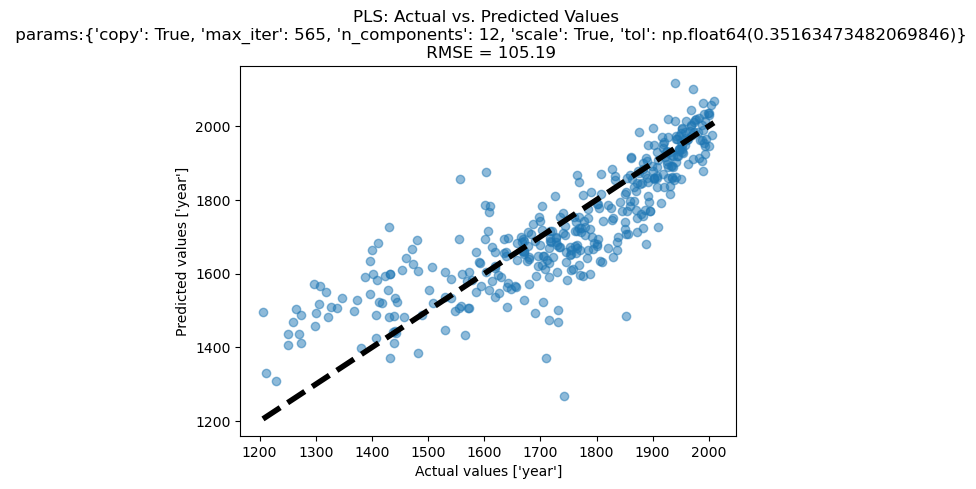

In [56]:
# plot
title_str = (
    f"PLS: Actual vs. Predicted Values \n params:"
    + optimal_params_str_pls
    + f"\n RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_pls)):.2f}"
)

param_dict = {"title": title_str}
fig_path = f"{FIGURE_PATH}/avp_pls.png"

fig, ax = plt.subplots(1, 1)
pls_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_pls, param_dict, fig_path)

# KKR Regressor - RSCV

In [57]:
from sklearn.kernel_ridge import KernelRidge as KRR

krr = KRR()
krr_rscv_results_file = f"{RESULTS_PATH}/krr_rscv_results.csv"

rscv(
    features=X,
    target=y,
    model=krr,
    param_distributions=krr_rscv_parameters,
    results_file=krr_rscv_results_file,
    random_state=random_state,
)

2024-06-26 21:32:00 - INFO - STARTED the RandomizedSearchCV for KernelRidge() with 5 trials
2024-06-26 21:32:00 - INFO - Features: (1290, 410), Target: (1290,), Model: KernelRidge(), Param_distributions: {'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0a5ccc5580>, 'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0a5ce6a2a0>, 'kernel': ['rbf', 'linear', 'poly', 'polynomial', 'chi2']}, Results File: ../03_Modelling/03_1_rscv/rscv_results//krr_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 5, nfolds: 4, n_jobs: 5, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-26 21:32:00 - INFO - Results file: ../03_Modelling/03_1_rscv/rscv_results//krr_rscv_results.csv
2024-06-26 21:32:00 - INFO - Trial: 0 out of 5
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
4 fits failed out of 

Best hyperparameters for KernelRidge: {'alpha': np.float64(0.004114360785858859), 'gamma': np.float64(12240.79487241552), 'kernel': 'polynomial'}
Best score -106.15316814308434 for KernelRidge: -106.15316814308434
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.004114360785858859),
            gamma=np.float64(12240.79487241552), kernel='polynomial')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
8 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fhwn.ac.at/202375/.c

Best hyperparameters for KernelRidge: {'alpha': np.float64(0.007848333458616113), 'gamma': np.float64(95005.5827479323), 'kernel': 'polynomial'}
Best score -99.0293731774634 for KernelRidge: -99.0293731774634
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.007848333458616113),
            gamma=np.float64(95005.5827479323), kernel='polynomial')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
16 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fhwn.ac.at/202375/

Best hyperparameters for KernelRidge: {'alpha': np.float64(0.00014606330621303628), 'gamma': np.float64(168.5295563099496), 'kernel': 'poly'}
Best score -109.82446181750296 for KernelRidge: -109.82446181750296
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.00014606330621303628),
            gamma=np.float64(168.5295563099496), kernel='poly')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
8 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fhwn.ac.at/202375/.c

Best hyperparameters for KernelRidge: {'alpha': np.float64(8.176656748975834e-05), 'gamma': np.float64(2531.76131230786), 'kernel': 'rbf'}
Best score -101.05341241874899 for KernelRidge: -101.05341241874899
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(8.176656748975834e-05),
            gamma=np.float64(2531.76131230786), kernel='rbf')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
12 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fhwn.ac.at/202375/

Best hyperparameters for KernelRidge: {'alpha': np.float64(9.675089552221809e-05), 'gamma': np.float64(29223.40717080043), 'kernel': 'rbf'}
Best score -96.19532914673823 for KernelRidge: -96.19532914673823
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(9.675089552221809e-05),
            gamma=np.float64(29223.40717080043), kernel='rbf')


,model,MAE,RMSE,params
0,KernelRidge(),83.070508,110.205096,"{'alpha': 0.004114360785858859, 'gamma': 12240..."
1,KernelRidge(),93.508858,122.176844,"{'alpha': 0.007848333458616113, 'gamma': 95005..."
2,KernelRidge(),80.128747,107.302117,"{'alpha': 0.00014606330621303628, 'gamma': 168..."
3,KernelRidge(),79.436135,104.247441,"{'alpha': 8.176656748975834e-05, 'gamma': 2531..."
4,KernelRidge(),80.129217,107.699515,"{'alpha': 9.675089552221809e-05, 'gamma': 2922..."


In [58]:
# generate the actual vs. predicted plot

# import the optimal model parameters
krr_results = pd.read_csv(krr_rscv_results_file)

# select the model parameters with the lowest RMSE
optimal_params_str_krr = krr_results.loc[krr_results["RMSE"].idxmin(), "params"]
optimal_params_krr = dict(eval(optimal_params_str_krr))
krr_opt = KRR(**optimal_params_krr)

y_pred_krr = krr_opt.fit(X_train, y_train).predict(X_test)

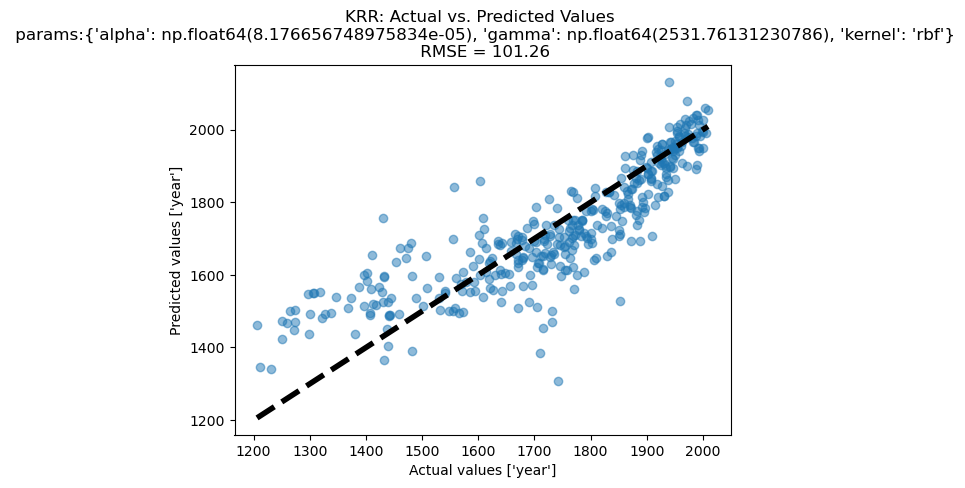

In [59]:
# plot
from al_lib.helper_functions import plot_actual_vs_pred

# break the optimal_params_str_krr string into more lines

title_str = (
    f"KRR: Actual vs. Predicted Values \n params:"
    + optimal_params_str_krr
    + f"\n RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_krr)):.2f}"
)

param_dict = {"title": title_str}
fig_path_krr = f"{FIGURE_PATH}/avp_krr.png"

fig, ax = plt.subplots(1, 1)
krr_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_krr, param_dict, fig_path_krr)

# MLP Regressor - RSCV

In [60]:
# import mlp
from sklearn.neural_network import MLPRegressor as MLP

mlp = MLP()
mlp_rscv_results_file = f"{RESULTS_PATH}/mlp_rscv_results.csv"

rscv_mpl = rscv(
    features=X,
    target=y,
    model=mlp,
    param_distributions=mlp_rscv_parameters,
    results_file=mlp_rscv_results_file,
    random_state=random_state,
)

2024-06-26 21:32:07 - INFO - STARTED the RandomizedSearchCV for MLPRegressor() with 5 trials
2024-06-26 21:32:07 - INFO - Features: (1290, 410), Target: (1290,), Model: MLPRegressor(), Param_distributions: {'hidden_layer_sizes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0a5ce69700>, 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0a5ce69400>, 'early_stopping': [True, False], 'validation_fraction': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0a5ce68a70>}, Results File: ../03_Modelling/03_1_rscv/rscv_results//mlp_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 5, nfolds: 4, n_jobs: 5, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-26 21:32:07 - INFO - Results file: ../03_Modelling/03_1_rscv/rscv_results//mlp_rscv_results.csv
2024-06-26 21:32:0

Best hyperparameters for MLPRegressor: {'activation': 'relu', 'alpha': np.float64(0.034868457854239636), 'early_stopping': True, 'hidden_layer_sizes': 83, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.18379677362428254)}
Best score -161.76813496101 for MLPRegressor: -161.76813496101
Best estimator for MLPRegressor: MLPRegressor(alpha=np.float64(0.034868457854239636), early_stopping=True,
             hidden_layer_sizes=83, solver='lbfgs',
             validation_fraction=np.float64(0.18379677362428254))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': np.float64(0.01856232102686737), 'early_stopping': False, 'hidden_layer_sizes': 131, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.11350471442686777)}
Best score -139.59362053993885 for MLPRegressor: -139.59362053993885
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=np.float64(0.01856232102686737),
             hidden_layer_sizes=131, solver='lbfgs',
             validation_fraction=np.float64(0.11350471442686777))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.

Best hyperparameters for MLPRegressor: {'activation': 'tanh', 'alpha': np.float64(0.09883327072570626), 'early_stopping': False, 'hidden_layer_sizes': 83, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.16316909032491644)}
Best score -158.7834084885626 for MLPRegressor: -158.7834084885626
Best estimator for MLPRegressor: MLPRegressor(activation='tanh', alpha=np.float64(0.09883327072570626),
             hidden_layer_sizes=83, solver='lbfgs',
             validation_fraction=np.float64(0.16316909032491644))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.

Best hyperparameters for MLPRegressor: {'activation': 'tanh', 'alpha': np.float64(0.07481083102194352), 'early_stopping': True, 'hidden_layer_sizes': 185, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.1675006729262935)}
Best score -146.05688699372297 for MLPRegressor: -146.05688699372297
Best estimator for MLPRegressor: MLPRegressor(activation='tanh', alpha=np.float64(0.07481083102194352),
             early_stopping=True, hidden_layer_sizes=185, solver='lbfgs',
             validation_fraction=np.float64(0.1675006729262935))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.


Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': np.float64(0.03749082061910696), 'early_stopping': True, 'hidden_layer_sizes': 108, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.19156966026716687)}
Best score -141.2919296872144 for MLPRegressor: -141.2919296872144
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=np.float64(0.03749082061910696),
             early_stopping=True, hidden_layer_sizes=108, solver='lbfgs',
             validation_fraction=np.float64(0.19156966026716687))


In [61]:
# generate the actual vs. predicted plot

# import the optimal model parameters
mlp_results = pd.read_csv(mlp_rscv_results_file)

# select the (optimal) model parameters with the lowest RMSE
optimal_params_str_mlp = mlp_results.loc[mlp_results["RMSE"].idxmin(), "params"]
optimal_params_mlp = dict(eval(optimal_params_str_mlp))

# fit the data with the optimal model parameters
mlp_opt = MLP(**optimal_params_mlp)

y_pred_mlp = mlp_opt.fit(X_train, y_train).predict(X_test)

/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


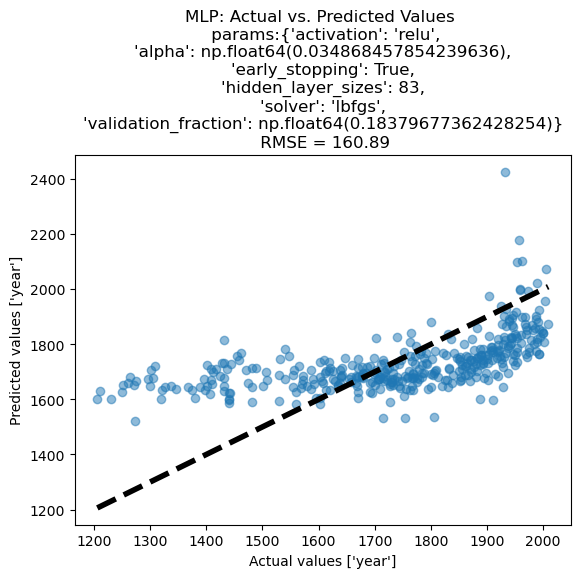

In [62]:
# plot
from al_lib.helper_functions import plot_actual_vs_pred

# break the optimal_params_str_mlp string into more lines
optimal_params_str_mlp_break = optimal_params_str_mlp.replace(", ", ",\n")

title_str = (
    f"MLP: Actual vs. Predicted Values \n params:"
    + optimal_params_str_mlp_break
    + f"\n RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_mlp)):.2f}"
)

param_dict = {"title": title_str}
fig_path_mlp = f"{FIGURE_PATH}/avp_mlp.png"

fig, ax = plt.subplots(1, 1)
mlp_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_mlp, param_dict, fig_path_mlp)

In [63]:
# import xgboost
import xgboost as xgb
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb_rscv_results_file = f"{RESULTS_PATH}/xgb_rscv_results.csv"

rscv_xgb = rscv(
    features=X,
    target=y,
    model=xgb,
    param_distributions=xgb_rscv_parameters,
    results_file=xgb_rscv_results_file,
    random_state=random_state,
)

2024-06-26 21:36:38 - INFO - STARTED the RandomizedSearchCV for XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) with 5 trials
2024-06-26 21:36:38 - INFO - Features: (1290, 410), Target: (1290,), Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, co

Best hyperparameters for XGBRegressor: {'colsample_bytree': np.float64(0.6310485371309444), 'gamma': np.float64(0.4308707199226964), 'learning_rate': np.float64(0.10337109739840987), 'max_depth': 9, 'n_estimators': 87, 'reg_alpha': np.float64(0.406459379710613), 'reg_lambda': np.float64(0.25986483600665883), 'subsample': np.float64(0.5552915287857241)}
Best score -97.81641680597039 for XGBRegressor: -97.81641680597039
Best estimator for XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.6310485371309444), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.4308707199226964), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.10337109739840987), max_bin=None,
             max_cat_thr

2024-06-26 21:38:49 - INFO - Trial: 2 out of 5


Best hyperparameters for XGBRegressor: {'colsample_bytree': np.float64(0.901009239167267), 'gamma': np.float64(0.31003874178233365), 'learning_rate': np.float64(0.08659884519418708), 'max_depth': 15, 'n_estimators': 88, 'reg_alpha': np.float64(0.2240520602011371), 'reg_lambda': np.float64(0.08149445088754725), 'subsample': np.float64(0.5671532900476488)}
Best score -100.02607338064485 for XGBRegressor: -100.02607338064485
Best estimator for XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.901009239167267), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.31003874178233365), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.08659884519418708), max_bin=None,
             max_cat

2024-06-26 21:40:52 - INFO - Trial: 3 out of 5


Best hyperparameters for XGBRegressor: {'colsample_bytree': np.float64(0.6977959974835447), 'gamma': np.float64(0.1673455277761587), 'learning_rate': np.float64(0.07436886816368649), 'max_depth': 14, 'n_estimators': 64, 'reg_alpha': np.float64(0.10369646890680362), 'reg_lambda': np.float64(0.3624380456831193), 'subsample': np.float64(0.594408055474044)}
Best score -97.55221549425475 for XGBRegressor: -97.55221549425475
Best estimator for XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.6977959974835447), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.1673455277761587), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.07436886816368649), max_bin=None,
             max_cat_th

/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-06-26 21:41:55 - INFO - Trial: 4 out of 5


Best hyperparameters for XGBRegressor: {'colsample_bytree': np.float64(0.7677850419719032), 'gamma': np.float64(0.07963907674805265), 'learning_rate': np.float64(0.10148554094748859), 'max_depth': 5, 'n_estimators': 75, 'reg_alpha': np.float64(0.46281489839848894), 'reg_lambda': np.float64(0.12641243323545776), 'subsample': np.float64(0.5247158745773726)}
Best score -97.20636263013625 for XGBRegressor: -97.20636263013625
Best estimator for XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.7677850419719032), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.07963907674805265), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.10148554094748859), max_bin=None,
             max_cat

2024-06-26 21:43:08 - INFO - FINISHED the RandomizedSearchCV for XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) with 5 trials


Best hyperparameters for XGBRegressor: {'colsample_bytree': np.float64(0.8937970906185244), 'gamma': np.float64(0.2601267241295943), 'learning_rate': np.float64(0.07154737518381205), 'max_depth': 16, 'n_estimators': 29, 'reg_alpha': np.float64(0.37778137608911744), 'reg_lambda': np.float64(0.46789462050999264), 'subsample': np.float64(0.8788974436136212)}
Best score -106.63929284146414 for XGBRegressor: -106.63929284146414
Best estimator for XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.8937970906185244), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.2601267241295943), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.07154737518381205), max_bin=None,
             max_ca

In [64]:
# generate the actual vs. predicted plot

# import the optimal model parameters
xgb_results = pd.read_csv(xgb_rscv_results_file)

# round the results to 4 decimal places
xgb_results = xgb_results.round(4)

# select the model parameters with the lowest RMSE
optimal_params_str_xgb = xgb_results.loc[xgb_results["RMSE"].idxmin(), "params"]
optimal_params_xgb = dict(eval(optimal_params_str_xgb))

# fit the data with the optimal model parameters
xgb_opt = XGBRegressor(**optimal_params_xgb)

y_pred_xgb = xgb_opt.fit(X_train, y_train).predict(X_test)

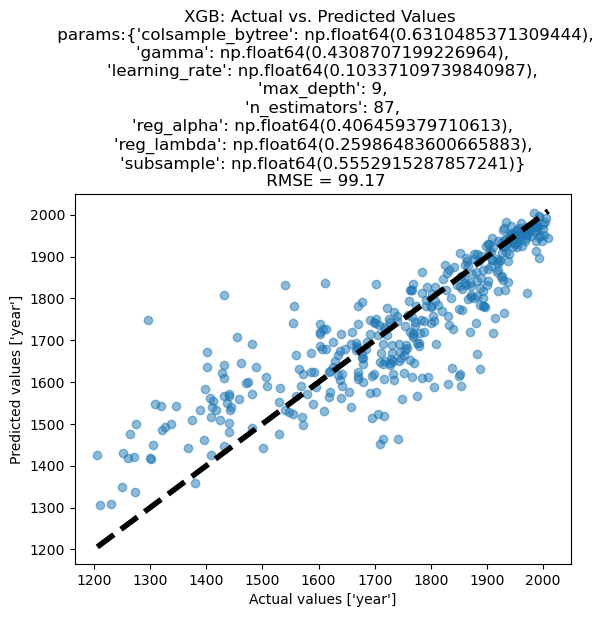

In [65]:
# plot
from al_lib.helper_functions import plot_actual_vs_pred

# break the optimal_params_str_ string into more lines
optimal_params_str_xgb_break = optimal_params_str_xgb.replace(", ", ",\n")


title_str = (
    f"XGB: Actual vs. Predicted Values \n params:"
    + optimal_params_str_xgb_break
    + f"\n RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}"
)

param_dict = {"title": title_str}
fig_path = f"{FIGURE_PATH}/avp_xgb.png"

fig, ax = plt.subplots(1, 1)
xgb_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_xgb, param_dict)

# HGB

In [66]:
# HGB
from sklearn.ensemble import HistGradientBoostingRegressor as HGB

hbg = HGB()
hgb_rscv_results_file = f"{RESULTS_PATH}/hgb_rscv_results.csv"

rscv_hgb = rscv(
    features=X,
    target=y,
    model=hbg,
    param_distributions=hgb_rscv_parameters,
    results_file=hgb_rscv_results_file,
    random_state=random_state,
)

2024-06-26 21:44:30 - INFO - STARTED the RandomizedSearchCV for HistGradientBoostingRegressor() with 5 trials
2024-06-26 21:44:30 - INFO - Features: (1290, 410), Target: (1290,), Model: HistGradientBoostingRegressor(), Param_distributions: {'loss': ['squared_error'], 'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0a5ce58e90>, 'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0a5ce59760>, 'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0a5ce59a90>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0a5ce59a00>}, Results File: ../03_Modelling/03_1_rscv/rscv_results//hgb_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 5, nfolds: 4, n_jobs: 5, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-26 21:44:30 - INFO - Results file: ../03_Modelling/03_1_rscv/rscv_results//hgb_rscv_re

Best hyperparameters for HistGradientBoostingRegressor: {'learning_rate': np.float64(0.01933173564816334), 'loss': 'squared_error', 'max_iter': 421, 'max_leaf_nodes': 20, 'min_samples_leaf': 23}
Best score -94.26593512281467 for HistGradientBoostingRegressor: -94.26593512281467
Best estimator for HistGradientBoostingRegressor: HistGradientBoostingRegressor(learning_rate=np.float64(0.01933173564816334),
                              max_iter=421, max_leaf_nodes=20,
                              min_samples_leaf=23)


2024-06-26 21:48:24 - INFO - Trial: 2 out of 5


Best hyperparameters for HistGradientBoostingRegressor: {'learning_rate': np.float64(0.036300904821883646), 'loss': 'squared_error', 'max_iter': 477, 'max_leaf_nodes': 18, 'min_samples_leaf': 22}
Best score -93.30384345454556 for HistGradientBoostingRegressor: -93.30384345454556
Best estimator for HistGradientBoostingRegressor: HistGradientBoostingRegressor(learning_rate=np.float64(0.036300904821883646),
                              max_iter=477, max_leaf_nodes=18,
                              min_samples_leaf=22)


2024-06-26 21:50:29 - INFO - Trial: 3 out of 5


Best hyperparameters for HistGradientBoostingRegressor: {'learning_rate': np.float64(0.0441280306074011), 'loss': 'squared_error', 'max_iter': 206, 'max_leaf_nodes': 30, 'min_samples_leaf': 29}
Best score -95.13176699945417 for HistGradientBoostingRegressor: -95.13176699945417
Best estimator for HistGradientBoostingRegressor: HistGradientBoostingRegressor(learning_rate=np.float64(0.0441280306074011),
                              max_iter=206, max_leaf_nodes=30,
                              min_samples_leaf=29)


2024-06-26 21:53:14 - INFO - Trial: 4 out of 5


Best hyperparameters for HistGradientBoostingRegressor: {'learning_rate': np.float64(0.05604891639294337), 'loss': 'squared_error', 'max_iter': 446, 'max_leaf_nodes': 65, 'min_samples_leaf': 23}
Best score -92.06106783607457 for HistGradientBoostingRegressor: -92.06106783607457
Best estimator for HistGradientBoostingRegressor: HistGradientBoostingRegressor(learning_rate=np.float64(0.05604891639294337),
                              max_iter=446, max_leaf_nodes=65,
                              min_samples_leaf=23)


2024-06-26 21:57:15 - INFO - FINISHED the RandomizedSearchCV for HistGradientBoostingRegressor() with 5 trials


Best hyperparameters for HistGradientBoostingRegressor: {'learning_rate': np.float64(0.10265990858988436), 'loss': 'squared_error', 'max_iter': 269, 'max_leaf_nodes': 19, 'min_samples_leaf': 30}
Best score -95.24419276918216 for HistGradientBoostingRegressor: -95.24419276918216
Best estimator for HistGradientBoostingRegressor: HistGradientBoostingRegressor(learning_rate=np.float64(0.10265990858988436),
                              max_iter=269, max_leaf_nodes=19,
                              min_samples_leaf=30)


In [67]:
# generate the actual vs. predicted plot
hgb_results = pd.read_csv(hgb_rscv_results_file)

# select the model parameters with the lowest RMSE
# select the model parameters with the lowest RMSE
optimal_params_str_hgb = hgb_results.loc[hgb_results["RMSE"].idxmin(), "params"]
optimal_params_hgb = dict(eval(optimal_params_str_hgb))

# fit the data with the optimal model parameters
hgb_opt = HGB(**optimal_params_hgb)

y_pred_hgb = hgb_opt.fit(X_train, y_train).predict(X_test)

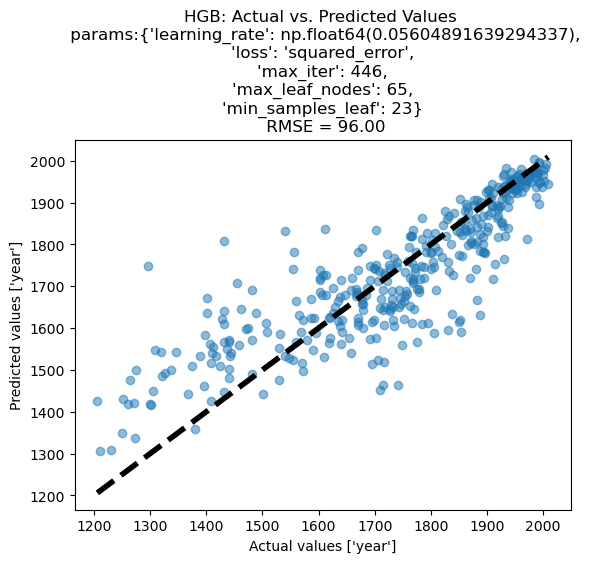

In [68]:
# plot
from al_lib.helper_functions import plot_actual_vs_pred

# break the optimal_params_str_ string into more lines
optimal_params_str_hgb_break = optimal_params_str_hgb.replace(", ", ",\n")


title_str = (
    f"HGB: Actual vs. Predicted Values \n params:"
    + optimal_params_str_hgb_break
    + f"\n RMSE = {root_mean_squared_error(y_test, y_pred_hgb):.2f}"
)
fig_path = f"{FIGURE_PATH}/avp_xgb.png"
param_dict = {"title": title_str}

fig, ax = plt.subplots(1, 1)
xgb_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_xgb, param_dict, fig_path)

# Quality Control

In this section the goal is to document the packages which where used during the execution of this notebook

In [69]:
## Package informations
from sklearn import show_versions

show_versions()


System:
    python: 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:23:07) [GCC 12.3.0]
executable: /home/fhwn.ac.at/202375/.conda/envs/thesis/bin/python
   machine: Linux-5.15.0-101-generic-x86_64-with-glibc2.31

Python dependencies:
      sklearn: 1.5.0
          pip: 24.0
   setuptools: 70.0.0
        numpy: 2.0.0
        scipy: 1.13.1
       Cython: None
       pandas: 2.2.2
   matplotlib: 3.8.4
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 80
         prefix: libopenblas
       filepath: /home/fhwn.ac.at/202375/.conda/envs/thesis/lib/libopenblasp-r0.3.27.so
        version: 0.3.27
threading_layer: pthreads
   architecture: SkylakeX

       user_api: openmp
   internal_api: openmp
    num_threads: 80
         prefix: libgomp
       filepath: /home/fhwn.ac.at/202375/.conda/envs/thesis/lib/libgomp.so.1.0.0
        version: None


In [70]:
import subprocess
import os
import datetime

# Add data/time information
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

# Create the output name from the notebookname

output_name = f"{notebook_name.split('.')[0]}_{date}.html"


# Function to convert the notebook to HTML
def convert_notebook_to_html(notebook_name, output_name):
    # Use subprocess to call the jupyter nbconvert command
    subprocess.call(["jupyter", "nbconvert", "--to", "html", notebook_name])
    # Rename the output file
    os.rename(notebook_name.split(".")[0] + ".html", output_name)


# Wait for a short period to ensure all cells have finished executing
time.sleep(5)  # Adjust the sleep duration as needed

# Convert the notebook to HTML
convert_notebook_to_html(notebook_name, output_name)

[NbConvertApp] Converting notebook 03_1_rscv.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 1588191 bytes to 03_1_rscv.html
